In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader

In [8]:
import os
sun_data=pd.read_csv('../input/sun-cases-all/all_sun_cases.csv')
sun_data.head()

,Case,Size
0,1,6mm
1,2,18mm
2,3,3mm
3,4,4mm
4,5,3mm


In [9]:
#Less than or equal to 
root_dir='../input/bounding-boxes-sun/Bounding Boxes/'
less_5=[]
less_10=[]
less_14=[]
less_18=[]
for idx in range(sun_data.shape[0]):
    item=sun_data['Size'][idx] 
    item=item[:-2]
    item=int(item)
    if item<=5:
        less_5.append(root_dir+'case'+str(sun_data['Case'][idx]))
    elif item <= 10:
        less_10.append(root_dir+'case'+str(sun_data['Case'][idx]))
    elif item <= 14:
        less_14.append(root_dir+'case'+str(sun_data['Case'][idx]))
    else:
        less_18.append(root_dir+'case'+str(sun_data['Case'][idx]))
print('Cases in :\nLess 5mm : {}\nLess 10mm : {}\nLess 14mm : {}\nLess 18mm : {}'.format(len(less_5),len(less_10),len(less_14),len(less_18)))

Cases in :
Less 5mm : 60
Less 10mm : 24
Less 14mm : 8
Less 18mm : 8


In [10]:
#Images per case
less_5_images=0
less_10_images=0
less_14_images=0
less_18_images=0
for idx in range(len(less_5)):
        try:
                images=os.listdir(less_5[idx])
                less_5_images+=(len(images))
        except: 
                continue
             
for idx in range(len(less_10)):
        try:
                images=os.listdir(less_10[idx])
                less_10_images+=(len(images))
        except:
                continue
for idx in range(len(less_14)):
        try:
                images=os.listdir(less_14[idx])
                less_14_images+=(len(images))
        except:
                continue
for idx in range(len(less_18)):
        try: 
                images=os.listdir(less_18[idx])
                less_18_images+=(len(images))
        except:
                continue
             

In [11]:
print('Less than 5 mm images: {}\nLess than 10mm images: {}\nLess than 14mm images: {}\nLess than 18mm images: {}'.format(less_5_images,less_10_images,less_14_images,less_18_images))

Less than 5 mm images: 23483
Less than 10mm images: 13133
Less than 14mm images: 3834
Less than 18mm images: 7799


In [12]:

#2D CNN:
import torch.nn as nn
class Net_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.batchnorm1=nn.BatchNorm2d(16)
        self.maxpool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.linear1=nn.Linear(28*28*64,128)
        self.linear2=nn.Linear(128,256)
        self.linear3=nn.Linear(256,4)
        
    def forward(self,x):
        out=self.conv1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv3(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=out.view(-1,28*28*64)
        out=self.linear1(out)
        out=self.relu(out)
        #out=nn.Dropout(p=0.5)
        out=self.linear2(out)
       # out=nn.Dropout(p=0.5)
        out=self.linear3(out)
        return out


class GrayScale_ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv4=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv5=nn.Conv2d(in_channels=32,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.conv6=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.conv7=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.batchnorm1=nn.BatchNorm2d(num_features=32)
        self.batchnorm2=nn.BatchNorm2d(num_features=32)
        self.batchnorm3=nn.BatchNorm2d(num_features=128)
        self.batchnorm4=nn.BatchNorm2d(num_features=128)
        self.leakyrelu=nn.LeakyReLU()
        self.dropout1=nn.Dropout2d(p=0.2)
        self.dropout2=nn.Dropout(p=0.5)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.linear1=nn.Linear(128,1024)
        self.linear2=nn.Linear(1024,512)
        self.linear3=nn.Linear(512,4)
    def forward(self,x):
        # dim: b x 1 x 224 x 224
        out=self.conv1(x)
        # dim: b x 16 x 224 x 224
        out=self.conv2(out)
        # dim: b x 32 x 224 x 224
        out=self.batchnorm1(out)
        # dim: b x 32 x 224 x 224
        out=self.leakyrelu(out)
        # dim: b x 32 x 224 x 224
        out1=self.maxpool(out)
        #print(out1.shape)
        #dim : b x 32 x 112 x 112
        out=self.conv3(out1)
        #dim : b x 32 x 112 x 112
        out=self.conv4(out)
        #dim : b x 32 x 112 x 112
        #print(out.shape)
        out=out+out1
        #dim : b x 32 x 112 x 112
        #print(out.shape)
        out=self.batchnorm2(out)
        #dim : b x 32 x 112 x 112
        out=self.leakyrelu(out)
        out=self.maxpool(out)
        out=self.dropout1(out)
        out=self.conv5(out)
        #dim : b x 128 x 112 x 112
        out=self.batchnorm3(out)
        out=self.leakyrelu(out)
        out2=self.maxpool(out)
        #dim : b x 128 x 56 x 56
        out=self.conv6(out2)
        #dim : b x 128 x 56 x 56
        out=self.conv7(out)
        #dim : b x 128 x 56 x 56
        out=out+out2
        #dim : b x 128 x 56 x 56
        out=self.batchnorm4(out)
        out=self.leakyrelu(out)
        out=self.maxpool(out)
        #dim : b x 128 x 28 x 28
        out=self.avgpool(out)
        #print(out.shape)
        #dim : b x 128 x 1 x 1
        out=out.view(-1,128)
        out=self.linear1(out)
        out=self.linear2(out)
        out=self.dropout2(out)
        out=self.linear3(out)
        
        
        return out
        
        
        



In [13]:
less_5=[item.split('/')[4] for item in less_5]
less_10=[item.split('/')[4] for item in less_10]
less_14=[item.split('/')[4] for item in less_14]
less_18=[item.split('/')[4] for item in less_18]

In [14]:
from tqdm import tqdm
#Assembling images into a dataframe:
#Directory for bounding boxes:
bbx_dir='../input/bounding-boxes-sun/Bounding Boxes/'
cases_bbx=os.listdir(bbx_dir)
cases_bbx=[os.path.join(bbx_dir,item) for item in cases_bbx]
columns=['Case','Image','Label']
polyp_data=pd.DataFrame(columns=columns)
for idx,item in tqdm(enumerate(cases_bbx)):
    
    case=cases_bbx[idx]
    case=case+'/'
    case_no=case.split('/')[4]
    if case_no in less_5:
        label=0
    elif case_no in less_10:
        label=1
    elif case_no in less_14:
        label=2
    else:
        label=3
    images=os.listdir(case)
    images=[os.path.join(case,item) for item in images]
    for index in range(len(images)):
        temp_data=pd.DataFrame({
            'Case':[case_no],
            'Image': [images[index]],
            'Label':[label]
        })
        polyp_data=pd.concat([polyp_data,temp_data],ignore_index='True')

97it [01:22,  1.17it/s]


In [15]:
import cv2
#Creating a custom dataloader:
tensor_pth='../input/sundepth224/Tensors/'
from  torch.utils.data import Dataset
class polyp_dataset(Dataset):
    def __init__(self,images_df):
        self.image_paths=images_df
    def __len__(self):
        return self.image_paths.shape[0]
    def get_labels(self):
        return self.image_paths['Label']
    def __getitem__(self,idx):
        img_path=self.image_paths['Image'][idx]
        img_name=img_path.split('/')[5]
        img_name=img_name.split('.')[0]
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(224,224))
        img=np.array(img,dtype='float32')
        case=self.image_paths['Case'][idx]
        tensor_cas=tensor_pth+case
        tensor_img=tensor_cas+'/'+img_name+'.pt'
        #print(tensor_img)
        #print(img.shape)
        tensor_img=torch.load(tensor_img)
        tensor_img=tensor_img.numpy()
        for row in range(tensor_img.shape[0]):
            for col in range(tensor_img.shape[1]):
                if img[row][col]==255:
                    img[row][col]= tensor_img[row][col]
       # plt.subplot(1,2,1)
        #plt.imshow(tensor_img,cmap='gray')
        tensor_img=img
        #plt.subplot(1,2,2)
        #plt.imshow(tensor_img,cmap='gray')
        tensor_img=tensor_img/255.0
        tensor_img=np.expand_dims(tensor_img,axis=0)
        tensor_img=torch.Tensor(tensor_img)
        label=self.image_paths['Label'][idx]
        return tensor_img,label

In [16]:
params={
    "device":'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size":64,
    "epochs":3,
    "lr":0.0001
}

In [17]:
#Creating train test and valid datasets
from sklearn.model_selection import train_test_split
Polyp_Train,Polyp_Valid=train_test_split(polyp_data,random_state=42,shuffle=True,test_size=0.2)
Polyp_Valid,Polyp_Test=train_test_split(Polyp_Valid,random_state=42,shuffle=True,test_size=0.5)

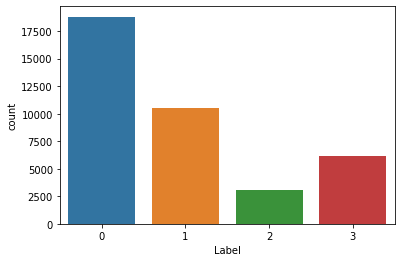

In [18]:
import seaborn as sns
sns.countplot(data=Polyp_Train,x=Polyp_Train['Label'])
plt.show()

In [19]:
print('Length of Training Data: {}\nLength of Testing Data: {}\nLength of Validation Data: {}'.format(Polyp_Train.shape[0],Polyp_Test.shape[0],Polyp_Valid.shape[0]))

Length of Training Data: 38599
Length of Testing Data: 4825
Length of Validation Data: 4825


In [20]:
#Reseting indices
Polyp_Train=Polyp_Train.reset_index()
Polyp_Train=Polyp_Train.drop(columns='index',axis=1)
#Polyp_Train=Polyp_Train.drop(columns='level_0',axis=1)
Polyp_Train.head()

,Case,Image,Label
0,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
1,case75,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case68,../input/bounding-boxes-sun/Bounding Boxes/cas...,3
3,case72,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
4,case80,../input/bounding-boxes-sun/Bounding Boxes/cas...,1


In [21]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test=Polyp_Test.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Test.head()

,Case,Image,Label
0,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
1,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case61,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
3,case95,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
4,case66,../input/bounding-boxes-sun/Bounding Boxes/cas...,1


In [22]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test=Polyp_Test.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Test.head()

,Case,Image,Label
0,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
1,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case61,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
3,case95,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
4,case66,../input/bounding-boxes-sun/Bounding Boxes/cas...,1


In [23]:
pip install torchsampler

Note: you may need to restart the kernel to use updated packages.


In [24]:
from torchsampler import ImbalancedDatasetSampler


In [25]:
#Creating datasets
train_dataset=polyp_dataset(Polyp_Train)
test_dataset=polyp_dataset(Polyp_Test)
validation_dataset=polyp_dataset(Polyp_Valid)

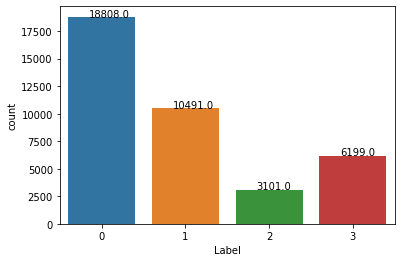

In [26]:
import seaborn as sns
ax=sns.countplot(data=Polyp_Train,x=Polyp_Train['Label'])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

In [23]:
#weights=[1./18808,1./10491,1.0/3101.0,1./6199.0]
#samples_weight = np.array([weights[t] for t in Polyp_Train['Label']])
#samples_weight = torch.from_numpy(samples_weight)
#from torch.utils.data import WeightedRandomSampler
#sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [27]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=64,
    
)

In [28]:
#Creating dataloaders
from torch.utils.data import DataLoader
#train_loader=DataLoader(dataset=train_dataset,num_workers=2,pin_memory=True,batch_size=params['batch_size'])
test_loader=DataLoader(dataset=test_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])
val_loader=DataLoader(dataset=validation_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])

In [ ]:
img,label=next(iter(train_loader))

In [ ]:
img.shape

In [29]:
model=Net_2D()
model=model.cuda()
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [27]:
num_epochs=2
train_loss=[]
train_accuracy=[]
testing_loss=[]
test_accuracy=[]
batch_accuracy=[]
min_btch_acc=0
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3)
for epoch in range(num_epochs):
    correct=0
    iterations=0
    iter_loss=0.0
    print('Started training for {} epochs'.format(num_epochs))
    model.train()
    print('Epoch: {}'.format((epoch+1)))
    for i,(inputs,labels) in enumerate(train_loader):
        
        batch_correct=0  
        inputs=inputs.cuda()
        labels=labels.cuda()
        output = model(inputs)
       
        loss= criterion(output,labels)
        
        iter_loss+=loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        _,predicted=torch.max(output,1)
        correct+=(predicted==labels).sum().item()
        batch_correct=(predicted==labels).sum().item()
        iterations+=1
        btch_acc=100*batch_correct/params["batch_size"]
        batch_accuracy.append(btch_acc)
        print('Iterations_completed: {}/{}, Batch_Loss: {:.3f},Batch_accuracy {:.3f} '.format(iterations,len(train_loader),iter_loss/iterations,btch_acc),end="\r")
    print('\n')
    torch.save('./four_classes_st_dict_model.pt',model.state_dict())
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100*correct/len(train_dataset))
    print('After one epoch, training accuracy is : {}\n'.format(train_accuracy[epoch]))
    
    

Started training for 2 epochs
Epoch: 1
Iterations_completed: 604/604, Batch_Loss: 0.761,Batch_accuracy 10.938 



AttributeError: 'collections.OrderedDict' object has no attribute 'flush'

In [30]:
torch.save(model,'./four_classes_model1.pt')
torch.save(model.state_dict(),'./four_classes_st_dict_model1.pt')

In [3]:
train_loss

NameError: name 'train_loss' is not defined

In [34]:
train_accuracy

[68.22974688463432]

In [32]:
import torch
model=torch.load('../input/model1/four_classes_model1.pt')

In [34]:
preds=[]
targets=[]
from tqdm import tqdm
with torch.no_grad():
    model.eval()
    for idx,data in tqdm(enumerate(test_loader)):
        img,label=data
        img=img.cuda()
        label=label.cuda()
        pred=model(img)
        _,pred=torch.max(pred,axis=1)
        preds.append(pred)
        targets.append(label)

76it [13:01, 10.29s/it]


In [35]:
new_preds=[]

for item in range(len(preds)):
    for idx in range(len(preds[item])):
        ele=preds[item][idx].cpu()
        new_preds.append(ele)

In [36]:
new_targets=[]


for item in range(len(targets)):
    for idx in range(len(targets[item])):
        ele=targets[item][idx].cpu()
        new_targets.append(ele)

In [37]:
new_targets=np.array(new_targets)
new_preds=np.array(new_preds)
for idx in range(new_targets.shape[0]):
    new_targets[idx]=int(new_targets[idx])
    new_preds[idx]=int(new_preds[idx])

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(new_targets,new_preds)

In [39]:
cm

array([[   0,   31, 2351,    0],
       [   0,   22, 1250,    0],
       [   0,    6,  344,    0],
       [   0,   21,  800,    0]])

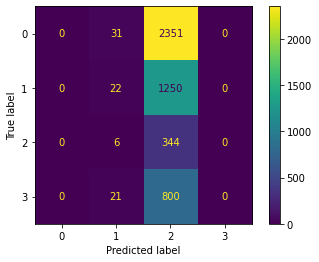

In [40]:
disp=ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()